In [108]:
import torch
import numpy as np
from neural_net import AgentNN
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder

## Define Hyperparameters

In [109]:
LR = 1e-3
N_EPOCHS = 20
BATCH_SIZE = 128
TEST_SIZE = 0.2

## Load and create dataset

In [110]:
Data = {
    'jump': [f for f in os.listdir("./expert_data/jump/")],
    'roll': [f for f in os.listdir("./expert_data/roll/")],
    'left': [f for f in os.listdir("./expert_data/left/")],
    'right': [f for f in os.listdir("./expert_data/right/")],
    'no_op': [f for f in os.listdir("./expert_data/no_op/")]
}

data_correct = {
    "observations": [sample for action, samples in Data.items() for sample in samples],
    "labels": [action for action, samples in Data.items() for sample in samples]
    }

data = pd.DataFrame(data_correct)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62238 entries, 0 to 62237
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   observations    62238 non-null  object
 1   labels          62238 non-null  object
 2   encoded_labels  62238 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [112]:
data.head(9000)

,observations,labels,encoded_labels
0,obs_729.npy,jump,0
1,obs_639.npy,jump,0
2,obs_3352.npy,jump,0
3,obs_2974.npy,jump,0
4,obs_3100.npy,jump,0
...,...,...,...
8995,obs_3327.npy,left,1
8996,obs_665.npy,left,1
8997,obs_6046.npy,left,1
8998,obs_4331.npy,left,1


In [113]:
# tr, val = train_test_split(data.labels, test_size=TEST_SIZE)
tr = data.labels

In [114]:
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(list(tr.index))
# valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(list(val.index))

In [93]:
# print(len(list(tr.index)))

In [115]:
class SubwaySurfers_Dataset(torch.utils.data.Dataset):
    def __init__(self, img_data, data_path):
        self.data_path = data_path
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_stack_name = os.path.join(self.data_path, self.img_data.loc[index, 'labels'], self.img_data.loc[index, 'observations'])
        image = np.load(img_stack_name)
        image = torch.tensor(image, dtype=torch.float32)

        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        
        return image, label

In [116]:
dataset = SubwaySurfers_Dataset(data, "/home/kumar-vedant/Documents/Development/subwaySurfersAI/expert_data/")

In [117]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
# validation_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_sampler)

## Create a model

In [118]:
model = AgentNN((4, 84, 84), 5)

In [119]:
print(model)

AgentNN(
  (conv_layers): Sequential(
    (0): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (network): Sequential(
    (0): Sequential(
      (0): Conv2d(4, 16, kernel_size=(8, 8), stride=(4, 4))
      (1): ReLU()
      (2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
      (3): ReLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
    )
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=3136, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=5, bias=True)
  )
)


## Define loss function and optimizer

In [120]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

## Train the network

In [121]:
for epoch in range(1, N_EPOCHS+1):
    running_loss = 0.0
    correct = 0
    total = 0
    total_step = len(train_loader)
    print(f'Epoch {epoch}\n')
    
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(model.device), target_.to(model.device) # on GPU

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward, backward, optimize
        outputs = model(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, N_EPOCHS, batch_idx, total_step, loss.item()))


Epoch 1

Epoch [1/20], Step [0/389], Loss: 3.0083
Epoch [1/20], Step [20/389], Loss: 1.0935
Epoch [1/20], Step [40/389], Loss: 1.0452
Epoch [1/20], Step [60/389], Loss: 0.9457
Epoch [1/20], Step [80/389], Loss: 0.9651
Epoch [1/20], Step [100/389], Loss: 0.7449
Epoch [1/20], Step [120/389], Loss: 0.9495
Epoch [1/20], Step [140/389], Loss: 0.9540
Epoch [1/20], Step [160/389], Loss: 0.9020
Epoch [1/20], Step [180/389], Loss: 0.8528
Epoch [1/20], Step [200/389], Loss: 0.8279
Epoch [1/20], Step [220/389], Loss: 0.7043
Epoch [1/20], Step [240/389], Loss: 0.9199
Epoch [1/20], Step [260/389], Loss: 0.8283
Epoch [1/20], Step [280/389], Loss: 0.7522
Epoch [1/20], Step [300/389], Loss: 0.6416
Epoch [1/20], Step [320/389], Loss: 0.6601
Epoch [1/20], Step [340/389], Loss: 0.8850
Epoch [1/20], Step [360/389], Loss: 0.9716
Epoch [1/20], Step [380/389], Loss: 0.6668
Epoch 2

Epoch [2/20], Step [0/389], Loss: 0.6837
Epoch [2/20], Step [20/389], Loss: 0.7332
Epoch [2/20], Step [40/389], Loss: 0.5983
Epo

KeyboardInterrupt: 

In [37]:
# model.load_state_dict(torch.load("./classification_model_0.pt"))

/tmp/ipykernel_5643/1196307034.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("./classification_model_0.pt"))


<All keys matched successfully>

In [101]:
X_test = val["labels"] + "/" + val["observations"]
y_test = data["encoded_labels"]

In [102]:
y_pred = [np.argmax(model.forward(torch.tensor(np.load("/home/kumar-vedant/Documents/Development/subwaySurfersAI/expert_data/" + img), dtype=torch.float32).to(model.device).unsqueeze(0)).cpu().detach().numpy()) for img in X_test]

In [44]:
test_img = torch.tensor(np.load("/home/kumar-vedant/Documents/Development/subwaySurfersAI/expert_data/roll/obs_0.npy"), dtype=torch.float32).to(model.device)
test_img = test_img.unsqueeze(0)

print(model.forward(test_img))
print(np.argmax(model.forward(test_img).cpu().detach().numpy()))

tensor([[  5.8970,  -4.2122,   2.8219, -18.9863,  20.4095]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
4


In [103]:
def evaluate(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # compute evaluation metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')

        metrics = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        }

        # print metrics
        print("Model Evaluation Metrics:")
        for metric_name, metric_value in metrics.items():
            print(f"{metric_name}: {metric_value:.4f}")

        # display confusion matrix heatmap
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(3, 2))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.show()

In [105]:
torch.save(model.state_dict(), "./classification_model_0.pt")

Model Evaluation Metrics:
Accuracy: 0.9870
Precision: 0.9870
Recall: 0.9870
F1-Score: 0.9870


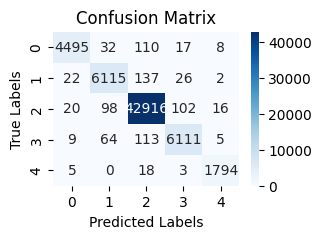

In [104]:
evaluate(y_test, y_pred)